# [Medical Insurance Cost Prediction](https://www.kaggle.com/mirichoi0218/insurance)

## Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.compose import ColumnTransformer, make_column_transformer


# Classifiers
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# classifiers / models
from sklearn.linear_model import LogisticRegression

# other
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
    
)

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, export_graphviz

## Data Collection & Analysis

In [2]:
# loading the data from csv file to a Pandas DataFrame
data = pd.read_csv('./data/insurance.csv')

In [3]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


- age: age of primary beneficiary

- sex: insurance contractor gender, female, male

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- children: Number of children covered by health insurance / Number of dependents

- smoker: Smoking

- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance

In [4]:
# number of rows and columns
data.shape

(1338, 7)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
meta = pd.DataFrame(index = data.columns)
meta["Unique_values"] = [len(set(data[col])) for col in data.columns]

In [8]:
meta

,Unique_values
age,47
sex,2
bmi,548
children,6
smoker,2
region,4
charges,1337


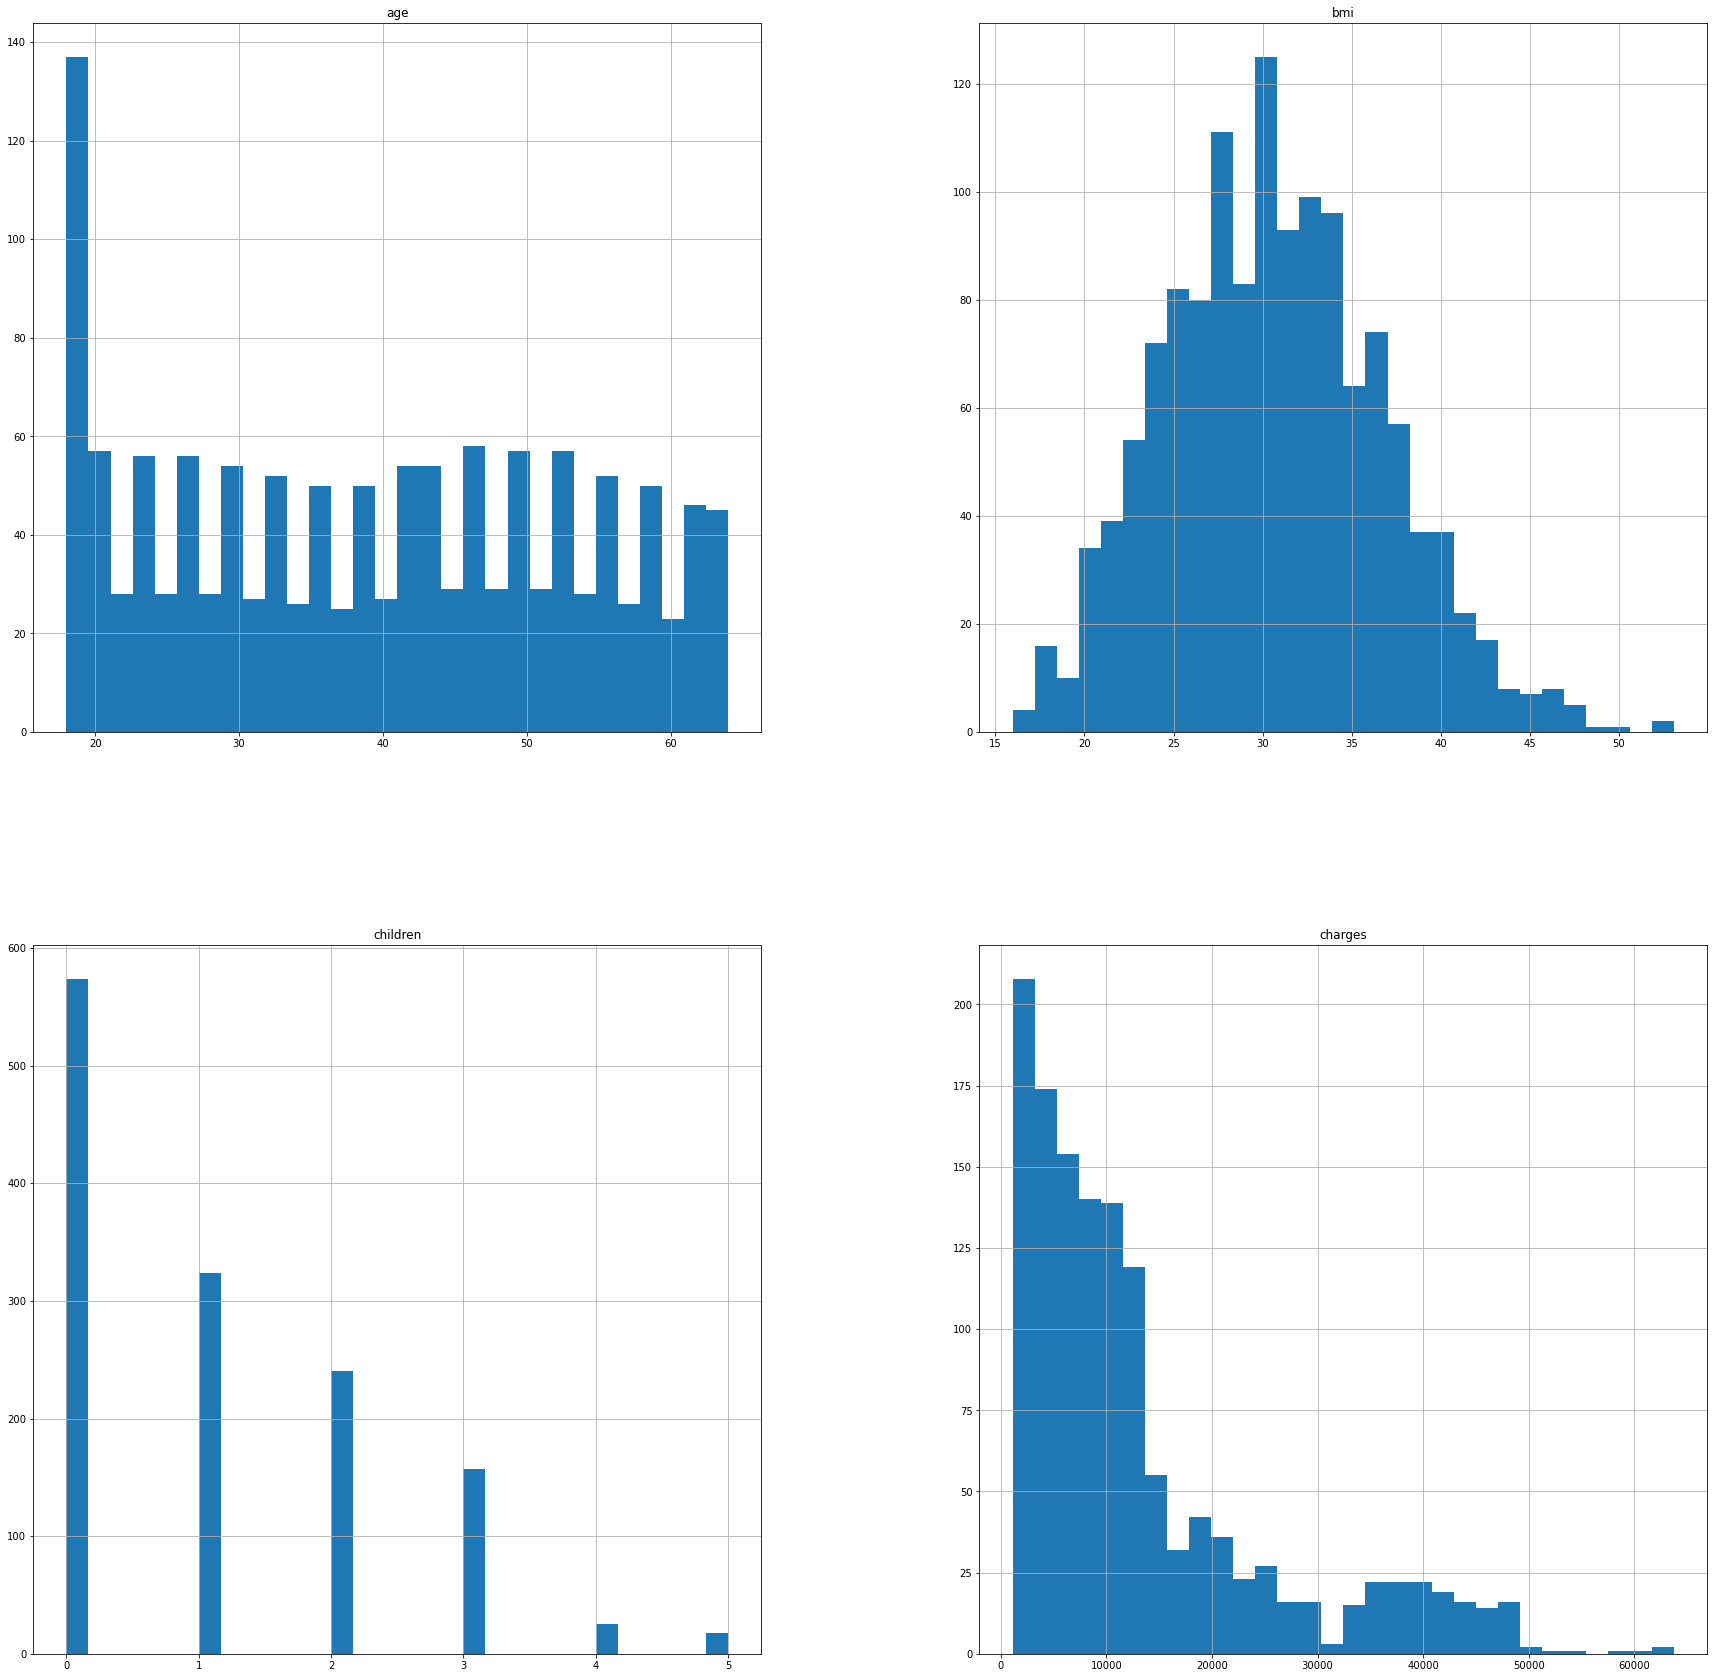

In [9]:
data.hist(figsize=(30,30), bins=30);

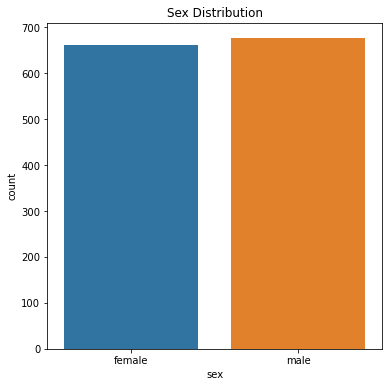

In [11]:
plt.figure(figsize=(6,6))
sns.countplot(x='sex', data=data)
plt.title('Sex Distribution')
plt.show()

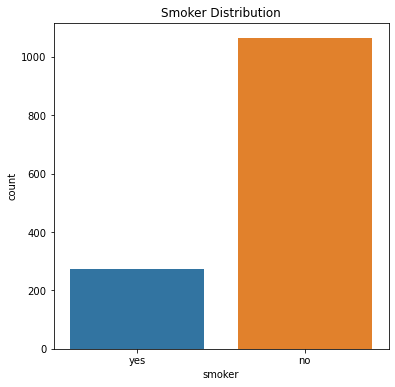

In [14]:
plt.figure(figsize=(6,6))
sns.countplot(x='smoker', data=data)
plt.title('Smoker Distribution')
plt.show()

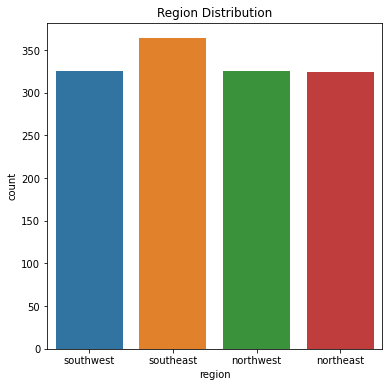

In [15]:
plt.figure(figsize=(6,6))
sns.countplot(x='region', data=data)
plt.title('Region Distribution')
plt.show()

## Data Preprocessing

In [16]:
train_df, test_df = train_test_split(data, test_size = 0.20, random_state = 2)
train_df

,age,sex,bmi,children,smoker,region,charges
882,21,female,22.135,0,no,northeast,2585.85065
505,37,male,30.875,3,no,northwest,6796.86325
798,58,female,33.100,0,no,southwest,11848.14100
792,22,female,23.180,0,no,northeast,2731.91220
201,48,female,32.230,1,no,southeast,8871.15170
...,...,...,...,...,...,...,...
466,60,female,28.700,1,no,southwest,13224.69300
299,48,female,28.880,1,no,northwest,9249.49520
493,61,male,43.400,0,no,southwest,12574.04900
527,51,female,25.800,1,no,southwest,9861.02500


In [17]:
target = "charges"
X_train, y_train = train_df.drop(columns=target), train_df[target]
X_test, y_test = test_df.drop(columns=target), test_df[target]

In [18]:
# drop_features = [""]
binary_features = ["sex", "smoker"]
# ordinal_features = []
categorical_features = ["region"]
numeric_features = list(set(train_df.columns)
#                        -set(drop_features)
                       -set([target])
                       -set(binary_features)
#                        -set(ordinal_encoded_features)
                       -set(categorical_features)
                       )

In [19]:
numeric_features

['children', 'age', 'bmi']

In [43]:
preprocessor = make_column_transformer(
     (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
)

In [40]:
#Defining Helper code adapted from DSCI573 Lab3
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [53]:
dummy = DummyRegressor(strategy = "mean")

results = {}

results["Dummy"] = mean_std_cross_val_scores(dummy, X_train, y_train, 
                                             return_train_score=True, scoring='r2')
pd.DataFrame(results)

,Dummy
fit_time,0.001 (+/- 0.000)
score_time,0.000 (+/- 0.000)
test_score,-0.007 (+/- 0.006)
train_score,0.000 (+/- 0.000)


In [59]:
from sklearn.metrics import mean_squared_error

dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print("MSE: %.2f" % mse)

MSE: 145576659.86


In [60]:
print("RMSE: %.2f" % (mse**(1/2.0)))

RMSE: 12065.52


In [64]:
pipe_lr = make_pipeline(
    preprocessor, LinearRegression()
)
results["linear_reg"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring="r2"
)
pd.DataFrame(results)

,Dummy,linear_reg
fit_time,0.001 (+/- 0.000),0.014 (+/- 0.005)
score_time,0.000 (+/- 0.000),0.009 (+/- 0.005)
test_score,-0.007 (+/- 0.006),0.735 (+/- 0.077)
train_score,0.000 (+/- 0.000),0.752 (+/- 0.017)


In [67]:
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print("MSE: %.2f" % mse)

MSE: 36100283.87


In [68]:
print("RMSE: %.2f" % (mse**(1/2.0)))

RMSE: 6008.35


In [72]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor


models = {
#     "RBF SVM": SVC(),
    "random forest": RandomForestRegressor(random_state=2),
    "xgboost": XGBRegressor(random_state=2),
    "lgbm": LGBMRegressor(random_state=2),
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring='r2'
    )

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),-0.007 (+/- 0.006),0.000 (+/- 0.000)
linear_reg,0.014 (+/- 0.005),0.009 (+/- 0.005),0.735 (+/- 0.077),0.752 (+/- 0.017)
random forest,0.207 (+/- 0.023),0.012 (+/- 0.001),0.830 (+/- 0.050),0.978 (+/- 0.002)
xgboost,0.044 (+/- 0.004),0.007 (+/- 0.001),0.802 (+/- 0.052),0.998 (+/- 0.001)
lgbm,0.055 (+/- 0.018),0.006 (+/- 0.000),0.828 (+/- 0.054),0.949 (+/- 0.005)


# To-do:
- feature selection
- hyperparameter opt
- interpretation & feature importance
- results on the test dataset
- summarize results